Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode='categorical',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

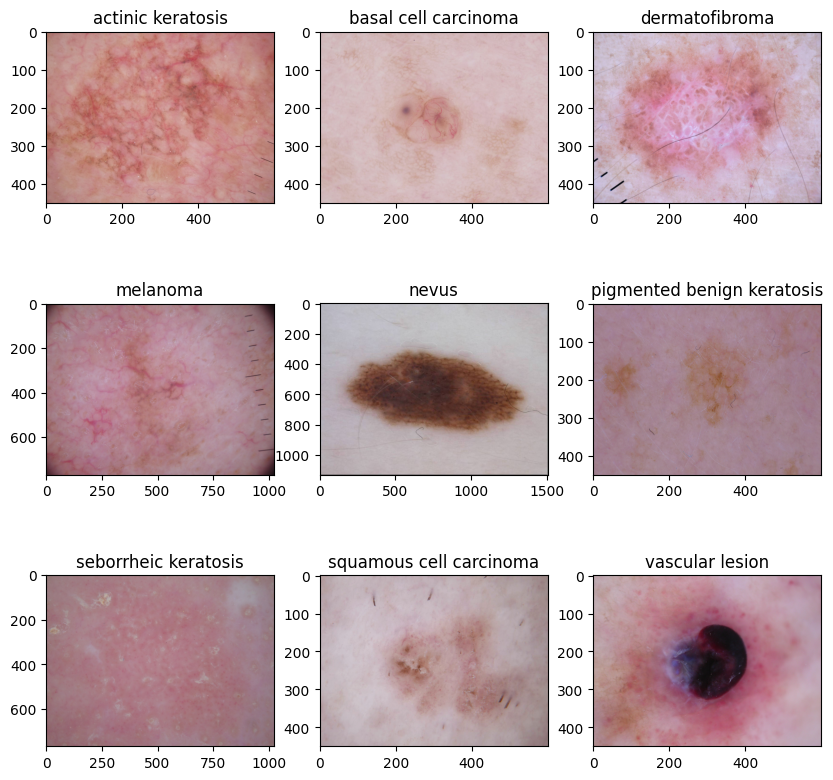

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
model = Sequential()

model.add(Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,699,401 (21.74 MB)

 Trainable params: 5,699,401 (21.74 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

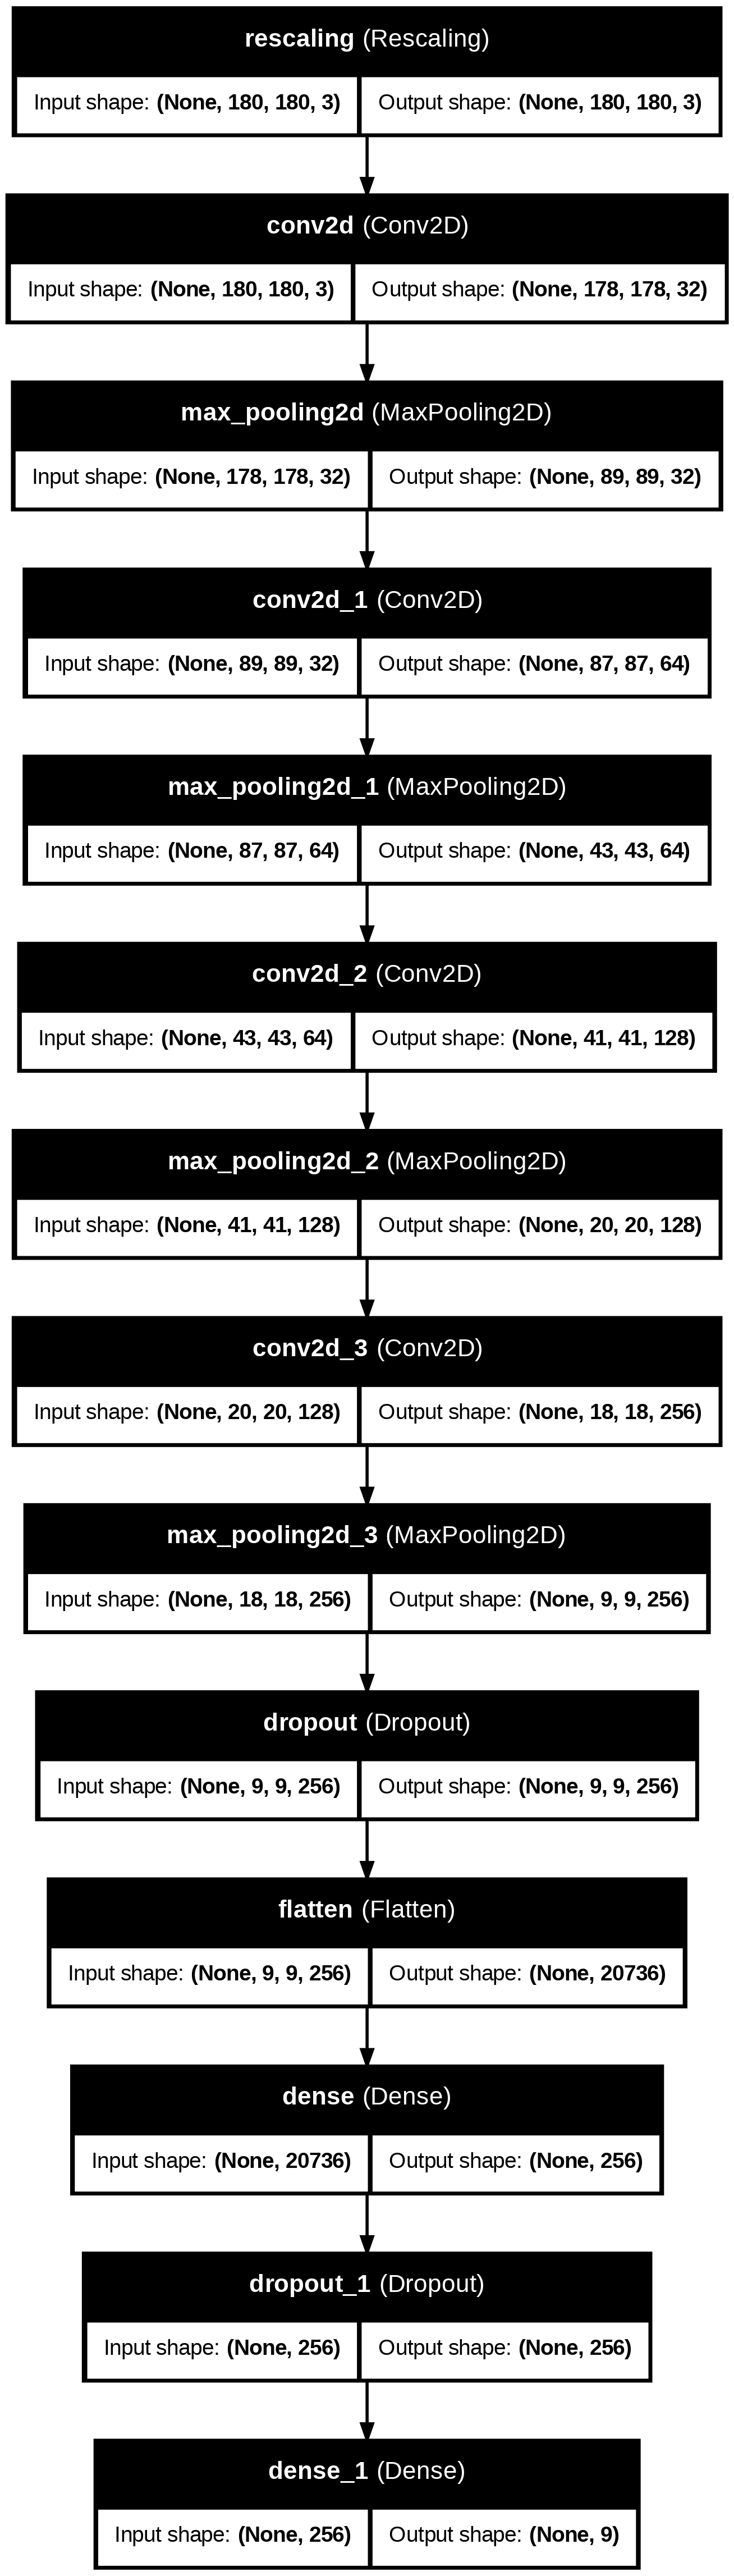

In [14]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=[checkpoint]
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0617 - accuracy: 0.2003
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to model.keras
56/56 [==============================] - 43s 650ms/step - loss: 2.0617 - accuracy: 0.2003 - val_loss: 1.8662 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7650 - accuracy: 0.3616
Epoch 2: val_accuracy improved from 0.33333 to 0.40492, saving model to model.keras
56/56 [==============================] - 35s 623ms/step - loss: 1.7650 - accuracy: 0.3616 - val_loss: 1.6823 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5973 - accuracy: 0.4224
Epoch 3: val_accuracy improved from 0.40492 to 0.46309, saving model to model.keras
56/56 [==============================] - 33s 583ms/step - loss: 1.5973 - accuracy: 0.4224 - val_loss: 1.5077 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.518

### Visualizing training results

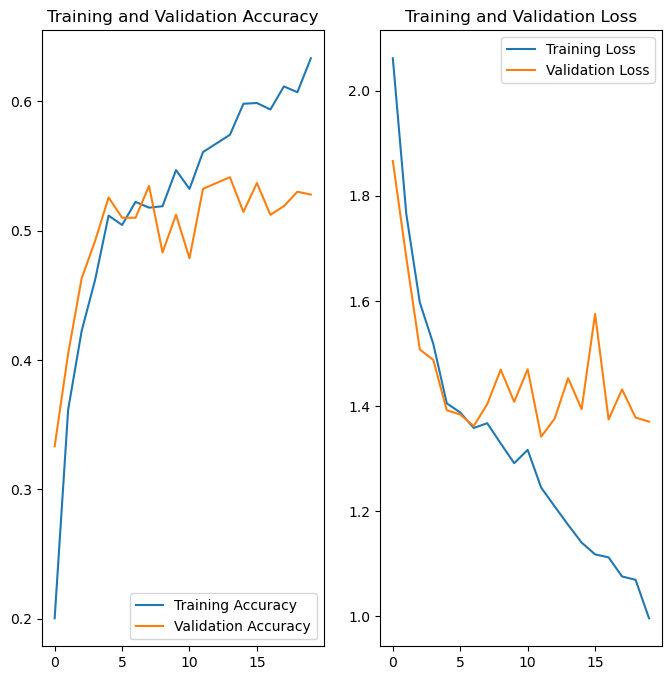

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:

Visualizing the model performance below shows there is overfitting of the model because the training loss is constantly decreasing but the validation loss is not. This shows that the model has memorized the training data patterns.

### Ways to boost the performance:
- Reduce the layers of the neural network
- Add dropout and tune its rate
- Apply L2 normalization and tune the lambda value
- Freeze the number of neurons in ach network layer so as to reduce the parameters
- Add more training data which is not always economical because of cost. The workaround is to augement the images.

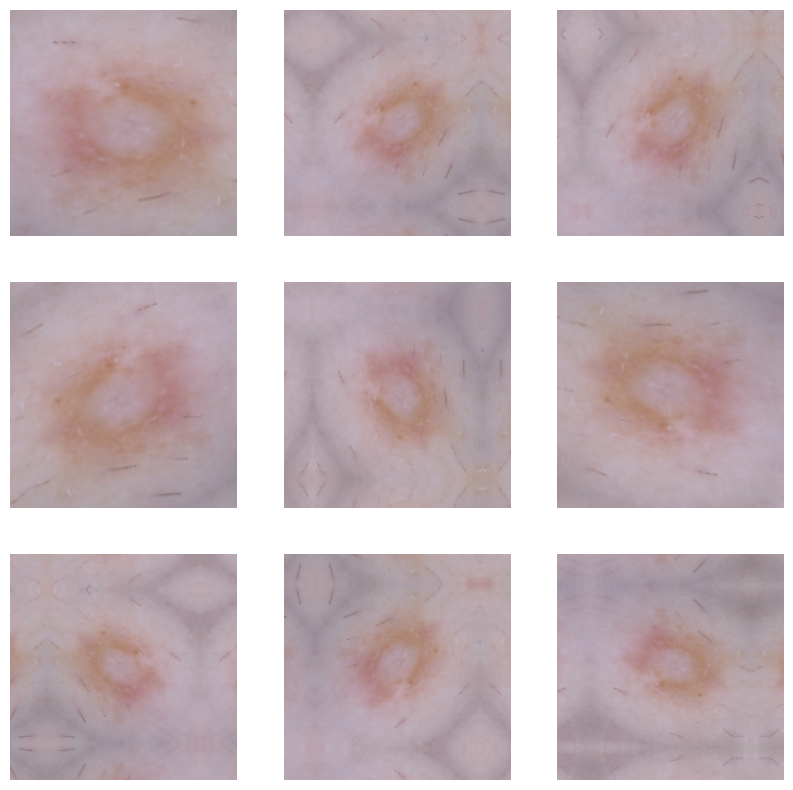

In [16]:
# visualize how your augmentation strategy works for one instance of training image.

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.5),
  ]
)

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")

### Create the model, compile and train the model

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([data_augmentation, Rescaling(1./255,input_shape=(180,180,3))])

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                  

### Compiling the model

In [ ]:
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                  

### Training the model

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=[checkpoint]
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.2814 - accuracy: 0.1802
Epoch 1: val_accuracy improved from -inf to 0.19239, saving model to model.keras
56/56 [==============================] - 115s 2s/step - loss: 2.2814 - accuracy: 0.1802 - val_loss: 2.0488 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.9425 - accuracy: 0.2740
Epoch 2: val_accuracy improved from 0.19239 to 0.35570, saving model to model.keras
56/56 [==============================] - 106s 2s/step - loss: 1.9425 - accuracy: 0.2740 - val_loss: 1.8513 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.7626 - accuracy: 0.3566
Epoch 3: val_accuracy improved from 0.35570 to 0.40045, saving model to model.keras
56/56 [==============================] - 105s 2s/step - loss: 1.7626 - accuracy: 0.3566 - val_loss: 1.6622 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.6347 - ac

### Visualizing the results

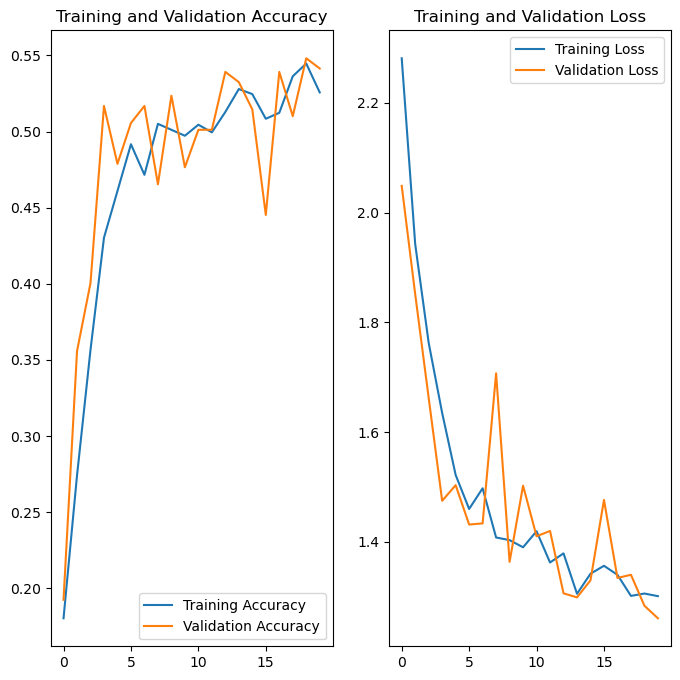

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
- The model does not seem to be overfitting or underfitting, however the performance is very low.
- There is a slight improvement in accuracy and loss for the validation dataset.

#### Finding the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [17]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [18]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

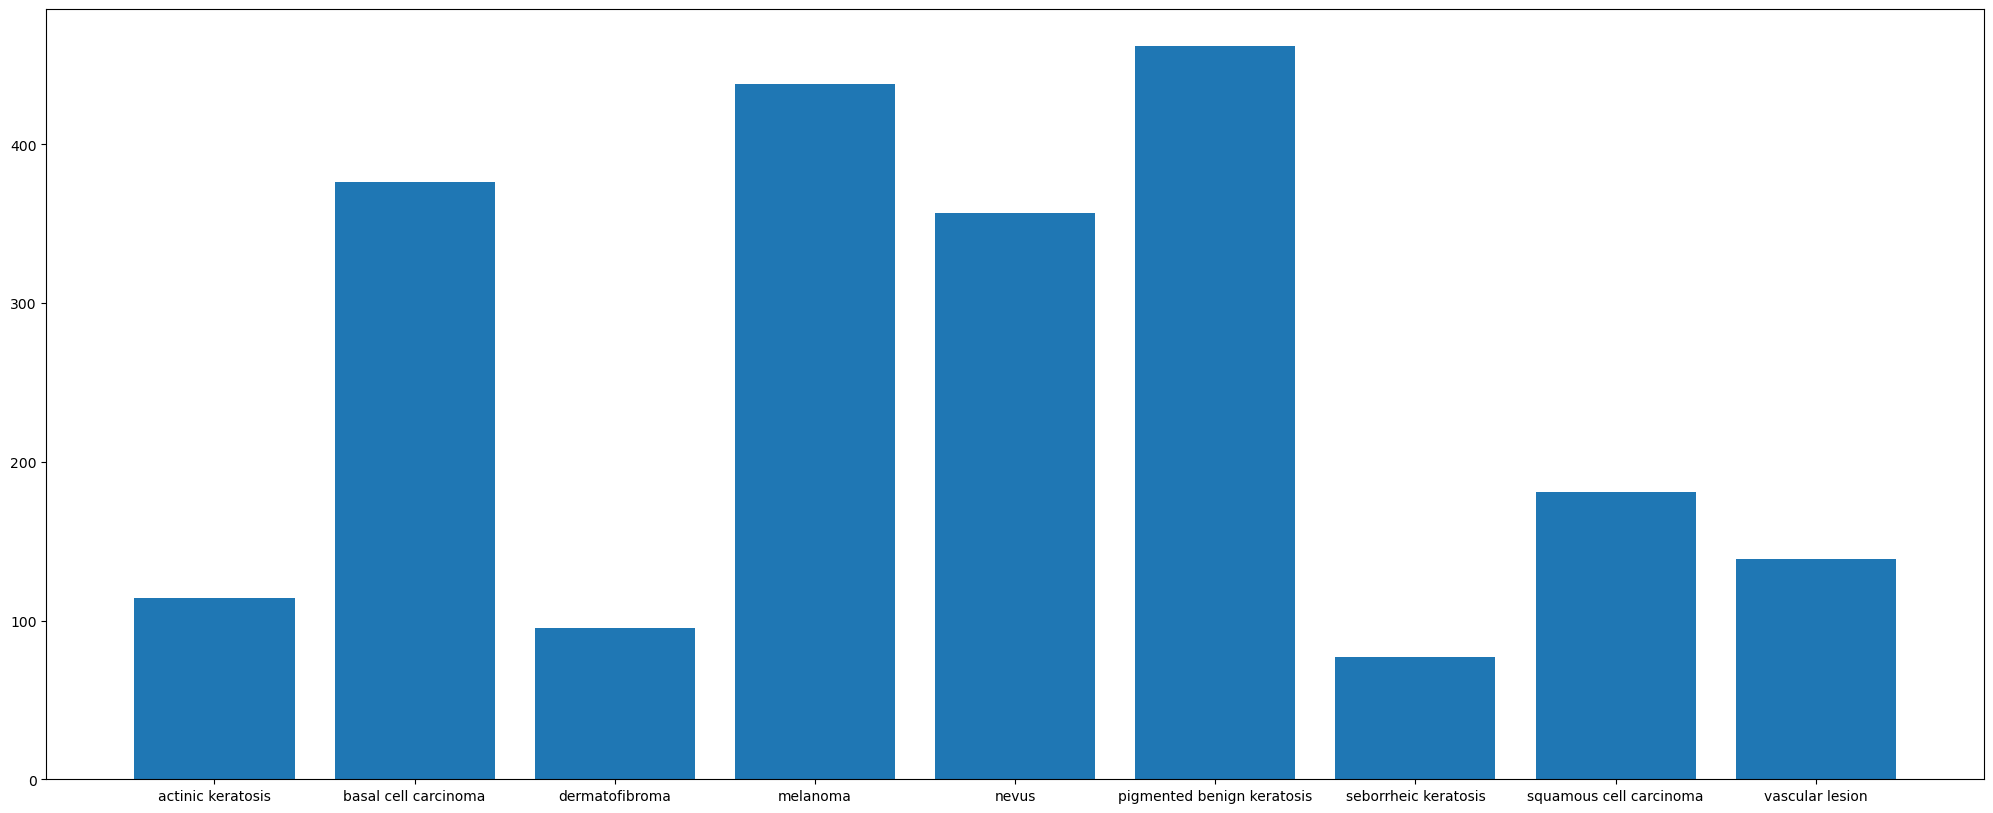

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings:
- _seborrheic keratosis_ has the least number of samples.
- _actinic keratosis_ and _dermatofibroma_ have proportionate number of classes. _
melanom_a and_ pigmented benign keratosi_s have proprtionate number of classes

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Rectify the class imbalance
**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [19]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [21]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B7EC0C5F4F0>: 100%|██████████| 500/500 [00:26<00:00, 19.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7EC0DFEDD0>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7EC0DFEE60>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7B7EC0FF54B0>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B7EC0F36080>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7EC9927FA0>: 100%|██████████| 500/500 [00:18<00:00, 26.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B7EC0DFC1C0>: 100%|██████████| 500/500 [00:46<00:00, 10.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7EC0FF5480>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7EC0CC7220>: 100%|██████████| 500/500 [00:19<00:00, 25.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [22]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [23]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_19a86099-5caf-4799-a9fb-4d49d1e293ed.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_29557fb0-ddb2-4ba7-b5ed-47719276f0ec.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_3682853e-7452-4bbc-99bd-8cd65bee62f8.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_e5f1c20c-8fc8-49dc-a128-bed5b0246510.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_6e9df574-e344-4c79-b60c-2e3b1ba7ff6d.jpg',
 '/content/Skin cancer ISIC The International

In [24]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [25]:
for i in class_names:

    for j in pathlib.Path(path_to_training_dataset).glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
4473,/content/Skin cancer ISIC The International Sk...,vascular lesion
4474,/content/Skin cancer ISIC The International Sk...,vascular lesion
4475,/content/Skin cancer ISIC The International Sk...,vascular lesion
4476,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [ ]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1386
melanoma                      1314
basal cell carcinoma          1128
nevus                         1071
squamous cell carcinoma        543
vascular lesion                417
actinic keratosis              364
dermatofibroma                 285
seborrheic keratosis           231
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train=pathlib.Path(path_to_training_dataset)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential([Rescaling(1./255,input_shape=(180,180,3))])

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

#Batch normalization
model.add(BatchNormalization())

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#### Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=[checkpoint]
)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 1.7253 - accuracy: 0.3733
Epoch 1: val_accuracy improved from -inf to 0.33705, saving model to model.keras
169/169 [==============================] - 192s 1s/step - loss: 1.7253 - accuracy: 0.3733 - val_loss: 1.8712 - val_accuracy: 0.3370
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 1.4993 - accuracy: 0.4362
Epoch 2: val_accuracy improved from 0.33705 to 0.36377, saving model to model.keras
169/169 [==============================] - 189s 1s/step - loss: 1.4993 - accuracy: 0.4362 - val_loss: 1.9428 - val_accuracy: 0.3638
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 1.3386 - accuracy: 0.5056
Epoch 3: val_accuracy improved from 0.36377 to 0.50260, saving model to model.keras
169/169 [==============================] - 184s 1s/step - loss: 1.3386 - accuracy: 0.5056 - val_loss: 1.3178 - val_accuracy: 0.5026
Epoch 4/50
169/169 [==============================] - ETA: 0s - los

#### **Todo:**  Visualize the model results

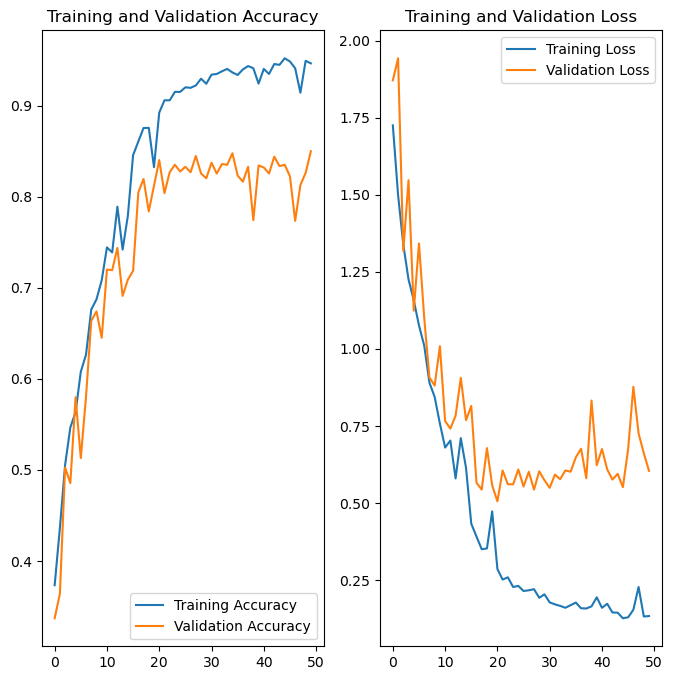

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy of the model did increase on the introduction of Augmentation.
- Model still overfits as the validation accuracy is very less compared to training accuracy.
- The problem of overfitting can be resolved if we add more layer, neurons and dropout layers.
- Hyperparameter tuning can be one way of further improvement.

#### validation accuracy achieved is 85%